#### Note:  I was training on my laptop and on Google Colab at the same time to speed things up. The training logs for the warandpeace_models (accuracy and logs) are in ML2.ipynb.

## Introduction

In this tutorial, we will build a character-level text autocomplete model using a Recurrent Neural Network (RNN) in PyTorch. We will train the model on the text from "warandpeace.txt". This project will help you understand how RNNs can be implemented for text generation tasks and their application in building your own autocomplete model.


## Importing Necessary Libraries

In [21]:
# This is Cell #1

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import random
import re
import matplotlib.pyplot as plt
import os
import pickle


## Setting Up the Device

In [2]:
# This is Cell #2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Reading and Preprocessing the Data

Now it is time to prepare our training data.


In [3]:
# This is Cell #3

def read_file(filename):
    with open(filename, "r", encoding="utf-8") as file:
        text = file.read().lower()
        # Keep only lowercase letters and standard punctuation (.,!?;:()[])
        text = re.sub(r'[^a-z.,!?;:()\[\] ]+', '', text)
    return text

### Here we will train our model with a simple sequence

We will start by training our model with a simple sequence and repettitive sequence such as `"abcdefghijklmnopqrstuvwxyzabcdef..."`, and we will see if our RNN is capable of learning that pattern or not. This will help you easily verify if your RNN is working correctly or not.

In [79]:
# This is Cell #4
sequence = "abcdefghijklmnopqrstuvwxyz" * 100
model_path = './basic_alphabet_models'

In [52]:
sequence = read_file('warandpeace.txt')

## Create Character Mappings

Creating character mappings is essential because RNNs require numerical input to process data. By mapping each unique character to an index and creating a reverse mapping, we convert text data into numerical sequences that the model can understand. This step allows us to encode input text for training and decode the model's output back into readable characters during text generation.



In [80]:
# This is Cell #5

#TODO: Create a list of unique characters from the text sequence
vocab = list(set(sequence))

#TODO: Create two dictionaries for character-index mappings that map each character in vocab to a unique index and vice versa
char_to_idx = {vocab[i]: i for i in range(len(vocab))}
idx_to_char = {i: vocab[i] for i in range(len(vocab))}

#TODO: Convert the entire text based data into numerical data
data = [char_to_idx[char] for char in sequence]


In [110]:
with open('./basic_alphabet_models/char_to_idx.pkl', 'wb') as f:
  pickle.dump(char_to_idx, f)

with open('./basic_alphabet_models/idx_to_char.pkl', 'wb') as f:
  pickle.dump(idx_to_char, f)

In [72]:
with open("./warandpeace_models/char_to_idx.pkl", 'rb') as f:
    char_to_idx = pickle.load(f)

with open("./warandpeace_models/idx_to_char.pkl", 'rb') as f:
    idx_to_char = pickle.load(f)

## Defining the CharDataset Class

Now we will create a custom dataset class to generate sequences and targets for training

Creating a custom `CharDataset` class is crucial because it prepares our text data into input sequences and target sequences that the RNN can learn from. By organizing the data this way, we can efficiently feed batches of sequences into the model during training, allowing it to learn the patterns of character sequences in the text.

In [81]:
# This is Cell #6

class CharDataset(Dataset):
    def __init__(self, data, sequence_length, stride, vocab_size):
        self.data = data
        self.sequence_length = sequence_length
        self.stride = stride
        self.vocab_size = vocab_size
        self.sequences = []
        self.targets = []
        
        # Create overlapping sequences with stride
        for i in range(0, len(data) - sequence_length, stride):
            self.sequences.append(data[i:i + sequence_length])
            self.targets.append(data[i + 1:i + sequence_length + 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return sequence, target
    

## Setting Hyperparameters

Now we will set our model's hyperparameters for our training process

Setting hyperparameters is important because they define the model's architecture and training behavior. They determine how the RNN processes data, learns patterns, and how quickly it converges during training. Properly chosen hyperparameters can significantly improve model performance and is a key step in training of models

Set the following hyperparameters for your model in the code cell below:
`sequence_length`, `stride`, `embedding_dim`, `hidden_size`, `num_layers`, `learning_rate`, `num_epochs`, `batch_size`, `vocab_size`.

In [55]:
# This is Cell #7

#TODO: Set your model's hyperparameters

sequence_length = 100  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 500     # Number of features in the hidden state of the RNN
learning_rate = 1e-3  # Learning rate for the optimizer
num_epochs = 10        # Number of epochs to train
batch_size = 64        # Batch size for training
vocab_size = len(vocab)
input_size = len(vocab)
output_size = len(vocab)


After you have set your hyperparameters in the code cell above, very breifly tell what is the role of each of the hyperparameter that you have defined above.

TODO: Explain below
> Sequence length: It determines the number of previous character embeddings that are used in calculating the hidden layer. 
> 
> Stride: It determines the separation between two sequences
> 
> Embedding_dim: It determines the dimensions of character embeddings.
> 
> Hidden_size: It determines the dimensions/num features of the hidden state that contains the context prior to the current character.
> 
> Learning rate: It determines how much each gradient descent/optimization step affects the model.
> 
> Num_epochs: It determines how many times the model trains through all the batches.
> 
> Batch_size: It determines the amount of data that is fed into the model for forward propagation before a step of optimization.
> 
> Vocab_size: The number of distinguish characters in the large sequence of text.
> 
> Input_size: The size of the dictionary of embeddings, same as vocab size in this case
> 
> Output_size: The size of the array that contains the score for each character in the vocab, same as vocab size in this case.

## Splitting Data into Training and Testing Sets

By now at this point in class, I'm confident that you know why we do this, so I'm not gonna say a lot here, let's jump right into the todo.

In [82]:
# This is Cell #8

data_tensor = torch.tensor(data, dtype=torch.long)

#TODO: Convert the data into a pytorch tensor and split the data into 90:10 ratio
train_size = int(data_tensor.size(0) * 0.9)
train_data, test_data = data_tensor.split([train_size, data_tensor.size(0) - train_size])

## Creating Data Loaders

Now we will create data loaders for easy batching during training and testing.

Creating data loaders is essential to batch the data during training and testing. Batching allows the RNN to process multiple sequences in parallel, which speeds up training and makes better use of computational resources. 
We will also use Data loaders to shuffle the batched data, which is important for training models that generalize well.

Make sure to set `drop_last=True`

In [84]:
# This is Cell #9

train_dataset = CharDataset(train_data, sequence_length, stride, vocab_size)
test_dataset = CharDataset(test_data, sequence_length, stride, vocab_size)

#TODO: Initialize the training and testing data loader with batching and shuffling equal to True for training (and shuffling = False for testing)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

total_batches = len(train_loader)

## Defining the RNN Model

Here we will define our character-level RNN model.

In [5]:
# This is Cell #10

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_dim=30):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_dim)
        self.W_e = nn.Parameter(torch.randn(hidden_size, embedding_dim) * 0.01)  # Smaller std
        self.b_e = nn.Parameter(torch.zeros(hidden_size))
        self.W_h = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)  # Smaller std
        self.b_h = nn.Parameter(torch.zeros(hidden_size)) 
        #TODO: set the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """
        x in [b, l] # b is batch_size and l is sequence length
        """
        x_embed = self.embedding(x)  # [b=batch_size, l=sequence_length, e=embedding_dim]
        b, l, _ = x_embed.size()
        x_embed = x_embed.transpose(0, 1) # [l, b, e]
        if hidden is None:
            h_t_minus_1 = self.init_hidden(b)
        else:
            h_t_minus_1 = hidden
        output = []
        for t in range(l):
            # RNN equation from the lecture 
            # We add a bias as well to expand the range of learnable functions
            h_t = torch.tanh(x_embed[t] @ self.W_e.T + self.b_e + h_t_minus_1 @ self.W_h.T + self.b_h) # [b, e]
            output.append(h_t)
            h_t_minus_1 = h_t
        output = torch.stack(output) # [l, b, e]
        output = output.transpose(0, 1) # [b, l, e]
        final_hidden = h_t.clone() # [b, h]
        logits = self.fc(output) # [b, l, vocab_size=v] 
        return logits, final_hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(device)


For a basic high level understanding of what is the CharRNN model that you just defined above, it consists of an embedding layer, an RNN layer, and a fully connected layer. Then embedding layer converts character indices into embeddings. Then RNN processes the embeddings and captures sequential information. Then finally the fully connected layer maps the RNN outputs to the vocabulary size for character prediction.


# Initializing the Model, Loss Function, and Optimizer

Now we will create an instance of the model that we just defined above and set up the loss function and optimizer. Then we will define a loss function, that evaluates the model's prediction against the true targets, and attaches a cost (number) on how good/bad the model is doing. During our training process, it is this cost that we try to minimize by tweaking the weights of the network. 

Then we will set up an optimizer, which will update the model's parameters based on the loss returned by the our loss function. This is how our model will learn over time.


In [108]:
# This is Cell #12

#TODO: Initialize your RNN model
model = CharRNN(input_size, hidden_size, output_size, embedding_dim)

#TODO: Define the loss function (use cross entropy loss)
criterion = nn.CrossEntropyLoss()

#TODO: Initialize your optimizer passing your model parameters and training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Training the Model

Now finally, after all the setup that we have done, we can train our RNN. 

A basic idea high level idea of what we will do here is we will loop over epochs and batches to train the model. 
We will Initialize the hidden state at the beginning of each epoch. For each batch, we will reset the gradients, perform a forward pass, compute the loss, perform backpropagation, and update the model parameters. Then we detach the hidden state to prevent gradients from backpropagating through previous batches. We ill repeat this process for each batch. And finally we will calculate the average loss and accuracy for each epoch.
By performing forward and backward passes, calculating loss, and updating the model parameters, we enable the RNN to improve its predictions with each epoch.

Epoch 1/40:   0%|          | 0/2 [00:00<?, ?it/s]/var/folders/jx/gpl581kj3ps18jk73ly90pt80000gn/T/ipykernel_50240/1273917643.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
/var/folders/jx/gpl581kj3ps18jk73ly90pt80000gn/T/ipykernel_50240/1273917643.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.targets[idx], dtype=torch.long)
Epoch 1/40: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch [1/40], Loss: 1009.3695, Accuracy: 5.77%


Epoch 2/40: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [2/40], Loss: 500.1909, Accuracy: 71.14%


Epoch 3/40: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch [3/40], Loss: 241.7917, Accuracy: 86.54%


Epoch 4/40: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch [4/40], Loss: 134.7996, Accuracy: 88.47%


Epoch 5/40: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch [5/40], Loss: 6.2631, Accuracy: 98.08%


Epoch 6/40: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch [6/40], Loss: 0.2043, Accuracy: 100.00%


Epoch 7/40: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [7/40], Loss: 84.4335, Accuracy: 96.15%


Epoch 8/40: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch [8/40], Loss: 120.9919, Accuracy: 96.16%


Epoch 9/40: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch [9/40], Loss: 11.8734, Accuracy: 98.07%


Epoch 10/40: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch [10/40], Loss: 0.0001, Accuracy: 100.00%


Epoch 11/40: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch [11/40], Loss: 0.0018, Accuracy: 100.00%


Epoch 12/40: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [12/40], Loss: 322.1545, Accuracy: 96.15%


Epoch 13/40: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch [13/40], Loss: 62.7271, Accuracy: 96.16%


Epoch 14/40: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch [14/40], Loss: 6.7360, Accuracy: 98.07%


Epoch 15/40: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch [15/40], Loss: 0.9317, Accuracy: 98.07%


Epoch 16/40: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch [16/40], Loss: 0.1089, Accuracy: 100.00%


Epoch 17/40: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch [17/40], Loss: 18.2478, Accuracy: 96.16%


Epoch 18/40: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Epoch [18/40], Loss: 0.0387, Accuracy: 100.00%


Epoch 19/40: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch [19/40], Loss: 0.0450, Accuracy: 100.00%


Epoch 20/40: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch [20/40], Loss: 0.0112, Accuracy: 100.00%


Epoch 21/40: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [21/40], Loss: 0.0049, Accuracy: 100.00%


Epoch 22/40: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch [22/40], Loss: 0.0380, Accuracy: 100.00%


Epoch 23/40: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch [23/40], Loss: 0.0446, Accuracy: 100.00%


Epoch 24/40: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch [24/40], Loss: 0.0272, Accuracy: 100.00%


Epoch 25/40: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Epoch [25/40], Loss: 2.3468, Accuracy: 98.08%


Epoch 26/40: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [26/40], Loss: 0.0020, Accuracy: 100.00%


Epoch 27/40: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch [27/40], Loss: 0.0239, Accuracy: 100.00%


Epoch 28/40: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch [28/40], Loss: 0.0052, Accuracy: 100.00%


Epoch 29/40: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch [29/40], Loss: 0.0147, Accuracy: 100.00%


Epoch 30/40: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch [30/40], Loss: 0.0026, Accuracy: 100.00%


Epoch 31/40: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch [31/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 32/40: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [32/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 33/40: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Epoch [33/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 34/40: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Epoch [34/40], Loss: 0.0016, Accuracy: 100.00%


Epoch 35/40: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Epoch [35/40], Loss: 0.0010, Accuracy: 100.00%


Epoch 36/40: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch [36/40], Loss: 0.0106, Accuracy: 100.00%


Epoch 37/40: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch [37/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 38/40: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch [38/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 39/40: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [39/40], Loss: 0.0000, Accuracy: 100.00%


Epoch 40/40: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

Epoch [40/40], Loss: 0.0000, Accuracy: 100.00%


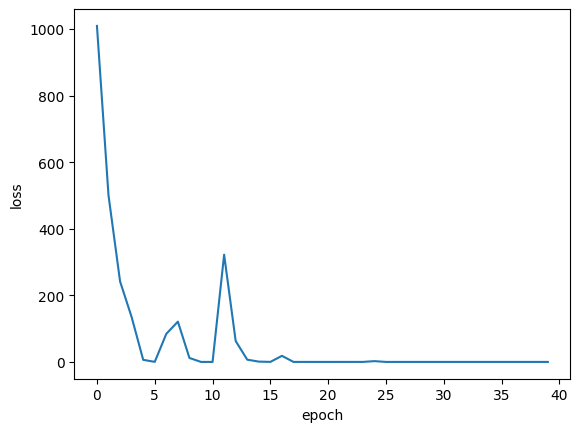

In [109]:
# This is Cell #13

losses = []
for epoch in range(num_epochs):
    total_loss, correct_predictions, total_predictions = 0, 0, 0

    hidden = model.init_hidden(batch_size)
    for batch_idx, (batch_inputs, batch_targets) in tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        output, hidden = model(batch_inputs, hidden)
        hidden = hidden.detach()
        #print([idx_to_char[int(c)] for c in torch.argmax(output, dim=1)[0]] )
        loss = criterion(output.view(-1, output_size), batch_targets.view(-1))  # Flatten the outputs and targets for CrossEntropyLoss
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.no_grad():
            # Calculate accuracy
            _, predicted_indices = torch.max(output, dim=2)  # Predicted characters

            correct_predictions += (predicted_indices == batch_targets).sum().item()
            total_predictions += batch_targets.size(0) * batch_targets.size(1)  # Total items in this batch

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions * 100  # Convert to percentage
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    losses.append(avg_loss)
    torch.save(model.state_dict(), os.path.join(model_path, f'epoch{epoch}.pth'))
    
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(losses)

Training hyperparameters for basic alphabet text:

In [107]:
sequence_length = 1000  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 30     # Number of features in the hidden state of the RNN
learning_rate = 200  # Learning rate for the optimizer
num_epochs = 40        # Number of epochs to train
batch_size = 64        # Batch size for training

Loss:

![](./basic_alphabet_models/basic_alphabet_model_training.png)

Training hyperparameters for War And Peace text:

In [125]:
sequence_length = 100  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 500     # Number of features in the hidden state of the RNN
learning_rate = 1e-3  # Learning rate for the optimizer
num_epochs = 10        # Number of epochs to train
batch_size = 64        # Batch size for training

Loss:  
![](./warandpeace_models/warandpeace_training.png)

## Check your loss

The training loss of your model when trained with a simple sequence like `"abcdefghijklmnopqrstuvwxyz" * 100` should be extremely close to zero. If that's not the case, go back and fix your bugs ;)

If you have acheived a training loss of 0 or extremley close to 0, then congratulations, lets move on to train your model with a bit more complicated sequence. That is our old favorite book, `warandpeace.txt`.

### Read the `warandpeace.txt` file

In [ ]:
# This is Cell #14
sequence = read_file('warandpeace.txt')

### Now Follow the instructions

1. Re-run Cell #5 to re-create character mappings for `warandpeace.txt`
2. Re-run Cell #7 to re-initialize hyperparameters
3. Re-run Cell #8 to split and create training and testing data with `warandpeace.txt` as your corpus
4. Re-run Cell #9 to set up data loaders with `warandpeace.txt` data
5. Re-run Cell #12 to re-initialize a new model object (maybe ask yourself why can't you use the previous model that was trained on the simple `"abc..."` corpus)
6. Re-run Cell #13 to train the new model with `warandpeace.txt` data.
   

## Evaluating the Model

After training, we evaluate the model on the test data.

In [ ]:
# This is Cell #15
avg_loss = 0
total_loss = 0
with torch.no_grad():
    #TODO: Write the testing loop for your trained model by refering to the training loop code given to you above
    total_loss, correct_predictions, total_predictions = 0, 0, 0

    hidden = model.init_hidden(batch_size)
    for batch_idx, (batch_inputs, batch_targets) in tqdm(enumerate(test_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        output, hidden = model(batch_inputs, hidden)
        hidden = hidden.detach()

        loss = criterion(output.view(-1, output_size), batch_targets.view(-1))  # Flatten the outputs and targets for CrossEntropyLoss

        # Calculate accuracy
        _, predicted_indices = torch.max(output, dim=2)  # Predicted characters

        correct_predictions += (predicted_indices == batch_targets).sum().item()
        total_predictions += batch_targets.size(0) * batch_targets.size(1)  # Total items in this batch

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions * 100  # Convert to percentage

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

## Generating Text with the Trained Model

In this part of the assignment, your task is to implement the `generate_text` function, which uses a trained RNN model to generate text character-by-character, continuing from a given input. The function will produce an extended sequence by repeatedly predicting and appending the next character to the input.

### What the function is supposed to do?

1. Take an initial input text of length `n` from the user, convert it into indices using a predefined vocabulary (char_to_idx).
2. Use a trained model to predict the next character in the sequence.
3. Append the predicted character to the input, extend the input sequence, and repeat the process until `k` additional characters are generated.
4. Return the generated text, including the original input and the newly predicted characters.


In [128]:
# This is Cell #16

def sample_from_output(logits, temperature=1.0):
    """
    Sample from the logits with temperature scaling.
    logits: Tensor of shape [batch_size, vocab_size] (raw scores, before softmax)
    temperature: a float controlling the randomness (higher = more random)
    """
    # Apply temperature scaling to logits (increase randomness with higher values)
    scaled_logits = logits / temperature  # Scale the logits by temperature
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(scaled_logits, dim=1)
    
    # Sample from the probability distribution
    sampled_idx = torch.multinomial(probabilities, 1)  # Sample one index from the probability distribution
    return sampled_idx

def generate_text(model, start_text, n, k, temperature=1.0):
    """
        model: The trained RNN model used for character prediction.
        start_text: The initial string of length `n` provided by the user to start the generation.
        n: The length of the initial input sequence.
        k: The number of additional characters to generate.
        temperature: Optional
        A scaling factor for randomness in predictions. Higher values (e.g., >1) make 
            predictions more random, while lower values (e.g., <1) make predictions more deterministic.
            Default is 1.0.
    """    
    start_text = start_text.lower()
    #TODO: Implement the rest of the generate_text function
    input_indices = [char_to_idx[c] for c in start_text]
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)
    hidden = model.init_hidden(batch_size=1)
    generated_str = ''
    with torch.no_grad():
        for _ in range(k):
            output, hidden = model(input_tensor, hidden)
            last_output = output[:, -1, :]
            predicted_idx = sample_from_output(last_output, temperature=temperature)
            predicted_char = idx_to_char[int(predicted_idx)]
            generated_str += predicted_char
            input_tensor = predicted_idx

    return generated_str

print("Training complete. Now you can generate text.")

#start_text = input("Enter the initial text (n characters, or 'exit' to quit): ")
start_text = 'Due to light rain and fog that morning, the Los Angeles Police Department helicopters and most other air traffic were'

n = len(start_text) 
#k = int(input("Enter the number of characters to generate: "))
k = 500
#temperature_input = input("Enter the temperature value (1.0 is default, >1 is more random): ")
#temperature = float(temperature_input) if temperature_input else 1.0
with open("./warandpeace_models/char_to_idx.pkl", 'rb') as f:
    char_to_idx = pickle.load(f)

with open("./warandpeace_models/idx_to_char.pkl", 'rb') as f:
    idx_to_char = pickle.load(f)
temperature = 0.7
model = CharRNN(input_size, hidden_size, output_size, embedding_dim)
model.load_state_dict(torch.load("warandpeace_models/epoch9.pth", weights_only=True))
model.eval()

completed_text = generate_text(model, start_text, n, k, temperature)

print(f"Generated text: {start_text + completed_text}")

Training complete. Now you can generate text.
Generated text: Due to light rain and fog that morning, the Los Angeles Police Department helicopters and most other air traffic were stationed. why are you sharp to anyone.how do you know why he added whom she was splint something to the campaign.the whole country.who served as to whom he had drive up a whole of t the troops to the picket like him. then he might take care and great moment, and that the man appeal condition of the most interrupted him at the contrary interverias to see the command and went up to the hill, but i have to come and would have been a sign all it is as a visitorsalsk and his arms face, and bent his


In [122]:
start_text = 'a'

n = len(start_text) 
#k = int(input("Enter the number of characters to generate: "))
k = 500
#temperature_input = input("Enter the temperature value (1.0 is default, >1 is more random): ")
#temperature = float(temperature_input) if temperature_input else 1.0
with open("./basic_alphabet_models/char_to_idx.pkl", 'rb') as f:
    char_to_idx = pickle.load(f)

with open("./basic_alphabet_models/idx_to_char.pkl", 'rb') as f:
    idx_to_char = pickle.load(f)
temperature = 0.999
model = CharRNN(input_size, hidden_size, output_size, embedding_dim)
model.load_state_dict(torch.load("basic_alphabet_models/epoch4.pth", weights_only=True))
model.eval()

completed_text = generate_text(model, start_text, n, k, temperature)

print(f"Generated text: {start_text + completed_text}")

Generated text: abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefg


## Report section

In your report, describe your experiments and observations when training the model with two datasets: (1) the sequence `"abcdefghijklmnopqrstuvwxyz" * 100` and (2) the text from `warandpeace.txt`. Include the final loss values for both datasets and discuss how the generated text differed between the two. Explain the impact of changing the `temperature` parameter on the text generation, and provide examples. Reflect on the challenges you faced, your thought process during implementation, and the key insights you gained about RNNs and sequence modeling.


The training process for both models is similar, tweaking the hyper-parameters and see which works the best. The first sequence can easily produce a low loss as it's very simple, whereas the second text requires more training and tweaking. The final loss values for the first dataset is 0.0000 (both train and test), whereas the final train loss value for the second dataset is 1.2449, test loss is 0.1575. The text generated from the first model is always the same repetitive sequence of a-z no matter what the temperature is, whereas the second model becomes more readable and not repetitive at a moderate temperature. The temperature changes how static the text output is. A lower temperature means more static, making the text more likely to be repetitive, whereas a higher temperature is less static and generates more "creative" text. For example, a temperature of 0.0001 in the second model will produce a repetition of "the countess and the countess was saying that he was a spirit of", whereas a higher temperature will produce something like "sign all it is as a visitorsalsk and his arms face, and bent his", a combination of actual words and fake words, thus being more "creative".

The biggest challenge is tweaking the hyper-parameters. Training takes a long time so tuning such parameters is very time-consuming. I learned how to implement RNN in pytorch, and it is interesting to see the code and the math come together.